In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import math
import string

In [2]:
pd.options.mode.copy_on_write = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["figure.autolayout"] = True

In [3]:
def load_wang_pi_data():
    df = pd.read_excel("./data/wang_raw_data_mutation_rate_literature_updating3.xlsx", sheet_name="gs_gt", 
                       header=0, usecols="A,E")
    df = df.rename(columns={"Species": "species"}) 
    df["species"] = df["species"].str.lower()
    return df

In [4]:
def load_bergeron_mut_rate_data():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 9", 
                       header=1, usecols="A,J,R,S", skiprows=0)
    df = df.rename(columns={
        "Species name": "species", 
        "Generation time (years)": "gen_time",
        "Average yearly mutation rate (m_yearly)": "u_year_non_modeled",
        "Modeled rate per generation (m_generation_modeled)": "u_modeled"})
    df["u_gen_non_modeled"] = df["gen_time"] * df["u_year_non_modeled"]
    return df
    
def load_bergeron_CpG_frac_data():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 4", 
                       header=1, usecols="A:M", skiprows=0)
    # sum up column 2 to 11 (exclusive) to get total mutation count
    df["mutation count"] = df.iloc[:,2:11].sum(axis=1)
    df["perc_CpG>TpG"] = (df["% of all mutation in CpG"]/100) * (df["% of C > T in CpG"]/100) * 100
    df = df.rename(columns={"Species": "species", "Group": "group"})
    df = df[["species", "group", "perc_CpG>TpG", "mutation count"]]
    # drop last row because it is the total sum of mutations across all species
    df.drop(df.tail(1).index,inplace=True)
    df.loc[df["species"] == "Sphaerodactylus_macrolepis", "species"] = "Sphaerodactylus_inigoi"
    return df

def merge_bergeron_dfs():
    df_mu = load_bergeron_mut_rate_data()
    df_CpG = load_bergeron_CpG_frac_data()
    df_merge = pd.merge(df_CpG, df_mu, on=["species"])
    df_merge["u_CpG_gen_non_modeled"] = df_merge["u_gen_non_modeled"] * df_merge["perc_CpG>TpG"] / 100
    df_merge["u_CpG_year_non_modeled"] = df_merge["u_year_non_modeled"] * df_merge["perc_CpG>TpG"] / 100
    assert len(df_mu) == len(df_CpG) and len(df_mu) == len(df_merge)
    print(f"In total {len(df_merge)} species in Bergeron's dataset with mutation rate estimates, {df_merge['u_modeled'].isna().sum()} does not have a modeled per-generation mutation rate")
    df_merge["species"] = df_merge["species"].str.lower()
    return df_merge

def convert_wang_df_species_name(df):
    # Wang's species name are not delimited by '_'
    df["species"] = df.apply(lambda x: "_".join(x["species"].split(" ")), axis=1)
    # 2 species name have a mismatch
    w2b_map = {
        'gallus_gallus_domesticus': 'gallus_gallus', 
        'tupaia_chinensis_belangeri': 'tupaia_belangeri'
    }
    df = df.replace({"species": w2b_map})
    return df
    
def check_bergeron_wang_species(df_b, df_w):
    '''helper function to check that the species names in bergeron's dataset match that of wang's'''
    species_b = set(df_b["species"])
    species_w = set(df_w["species"])
    assert len(species_b - species_w) == 0
    
def merge_wang_bergeron_dfs():
    df_b = merge_bergeron_dfs()
    df_w = load_wang_pi_data()
    df_w_species_update = convert_wang_df_species_name(df_w)
    check_bergeron_wang_species(df_b, df_w_species_update)
    df_merge = pd.merge(df_b, df_w_species_update, on=["species"])
    assert len(df_merge) == len(df_b)
    print(f"After merging Wang and Bergeron's dataset, there are {len(df_merge)} species")
    
    # num_zero_diversity = np.count_nonzero(df_merge["diversity"] == 0)
    # species_zero_diversity = set(df_merge.loc[(df_merge['diversity'] == 0)]["species"])
    df_merge_div = df_merge[df_merge['diversity'] != 0]
    print(f"after filtering out species with 0 diversity, there are now {len(df_merge_div)} species")
    df_merge_div["Ne"] = df_merge_div["diversity"] / (4 * df_merge_div["u_gen_non_modeled"])
    df_merge_div["Ne*g"] = df_merge_div["Ne"] * df_merge_div["gen_time"]
    return df_merge_div
    
df_final = merge_wang_bergeron_dfs()

In total 68 species in Bergeron's dataset with mutation rate estimates, 13 does not have a modeled per-generation mutation rate
After merging Wang and Bergeron's dataset, there are 68 species
after filtering out species with 0 diversity, there are now 62 species


In [5]:
def plot_color_gradients(cmap_name, ax):
    """helper function, given a cmap name, visualize its color gradient"""
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    ax.imshow(gradient, aspect='auto', cmap=matplotlib.colormaps[cmap_name])
    ax.set_axis_off()

def get_color_index(num_groups, group_name_index):
    """Calculate an decimal index between (0.05, 1)"""
    return 1 - (0.05+ (1-0.05) / num_groups * group_name_index)

def plot_dbh_mu_vs_Ne(df, group_name2idx_map, colors, df_mutation_rate_key, df_ne_key, ax_mutation_rate_unit, ax_ne_unit, ax=None, add_legend=True, label_fontsize=15):
    """helper function, plot mutation rate vs effective population size, given the unit for mu and Ne"""
    if ax is None:
        fig, ax = plt.subplots()
        
    # due to renaming to stay consistent with phylogenetic tree
    df_human = df.loc[df.index[df["species"] == "homo_sapiens"]]
    human_ne, human_mu = df_human[df_ne_key].to_numpy()[0], df_human[df_mutation_rate_key].to_numpy()[0]
    df_mice = df.loc[df.index[df["species"] == "mus_musculus"]]
    mice_ne, mice_mu = df_mice[df_ne_key].to_numpy()[0], df_mice[df_mutation_rate_key].to_numpy()[0]
    ax.scatter(human_ne, human_mu, color=colors[group_name2idx_map["Primate"]], 
               marker='D', edgecolor="black", s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mice_ne, mice_mu, color=colors[group_name2idx_map["Mammal"]], 
               marker='D', edgecolor="blue", s=100, lw=2, zorder=float("inf")) #label="mice"
    offset_factor=1.1
    ax.text(offset_factor * human_ne, offset_factor * human_mu, "human", zorder=float("inf"), fontsize=15)
    ax.text(offset_factor * mice_ne, offset_factor * mice_mu, "mouse", zorder=float("inf"), fontsize=15)

    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group"] == gn]]
        ax.scatter(df_gn[df_ne_key], df_gn[df_mutation_rate_key], color=colors[idx], label=gn)
    
    if add_legend:
        ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    xlabel = r"$\bf{N_e}$" if ax_ne_unit == "Ne" else r"$\bf{N_e} \times$ generation time" 
    ax.set_xlabel(xlabel, fontsize=label_fontsize, weight="bold")
    ax.set_ylabel(f"mutation rate (/{ax_mutation_rate_unit})", fontsize=label_fontsize, weight="bold")
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    
    # grid line
    ax.grid(which="major", linestyle = "dashed")
    ax.set_axisbelow(True)

In [6]:
color_map_name = "nipy_spectral"
cmap = matplotlib.colormaps[color_map_name]  
vertebrate_group_name2idx_map = {
    "Primate": 0, 
    "Mammal": 1, 
    "Bird": 2,
    "Reptile": 3,
    "Fish": 4
} 

num_groups = len(vertebrate_group_name2idx_map)
colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]


## DBH plots for overall mutation rate

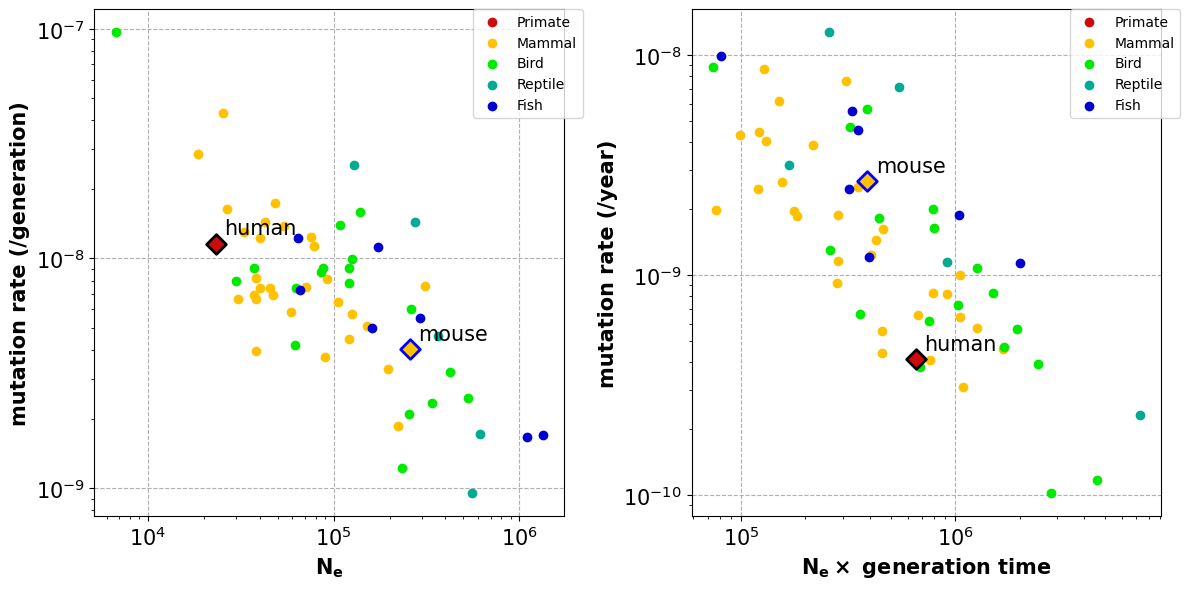

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plot_dbh_mu_vs_Ne(df_final, vertebrate_group_name2idx_map, colors, "u_gen_non_modeled", "Ne", "generation", "Ne", ax=ax[0])
plot_dbh_mu_vs_Ne(df_final, vertebrate_group_name2idx_map, colors, "u_year_non_modeled", "Ne*g", "year", "Ne*g", ax=ax[1])

## DBH plots for CpG mutation rate

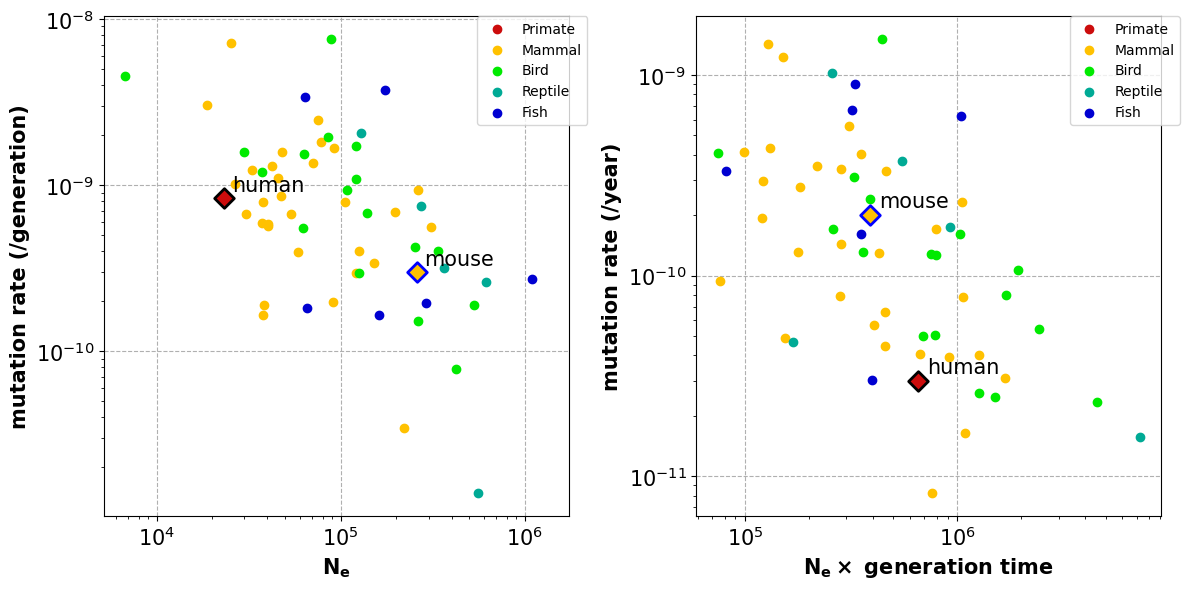

In [8]:
fig_cpg, ax_cpg = plt.subplots(1, 2, figsize=(12,6))
plot_dbh_mu_vs_Ne(df_final, vertebrate_group_name2idx_map, colors, "u_CpG_gen_non_modeled", "Ne", "generation", "Ne", ax=ax_cpg[0])
plot_dbh_mu_vs_Ne(df_final, vertebrate_group_name2idx_map, colors, "u_CpG_year_non_modeled", "Ne*g", "year", "Ne*g", ax=ax_cpg[1])